In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.nn.functional as F #relu,GD
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
in_channels = 3
num_classes = 4
batch_size = 64
learning_rate = 0.001
epochs = 50


In [4]:
class CNN(nn.Module):
    def __init__(self,in_channels,num_classes):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3,out_channels = 8,kernel_size =3,stride=1 )
        self.conv2 = nn.Conv2d(8,64,3,1)
        self.conv3 = nn.Conv2d(64,128,3,1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(128*26*26,128)
        self.fc2 = nn.Linear(128,num_classes)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0],-1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x





In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),            # Resize the image to (224, 224)
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),  # Random crop and resize
    transforms.RandomHorizontalFlip(p=0.5),   # Randomly flip horizontally with 50% probability
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),     # Randomly rotate by up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust color
    transforms.ToTensor(),                    # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

In [6]:
#Create Dataset
train_root = r"/kaggle/input/apple-disease-dataset/datasets/train"
test_root = r"/kaggle/input/apple-disease-dataset/datasets/test"

In [7]:
train_dataset = ImageFolder(train_root , transform =transform)
train_set,val_set = torch.utils.data.random_split(train_dataset,[6217,1554])
test_dataset = ImageFolder(test_root , transform = transform) 
#DataLoader
train_loader = DataLoader(train_set,batch_size = batch_size,shuffle = True,drop_last=True)
val_loader = DataLoader(val_set, batch_size = batch_size,drop_last = True)
test_loader = DataLoader(test_dataset,batch_size = batch_size,drop_last = True)

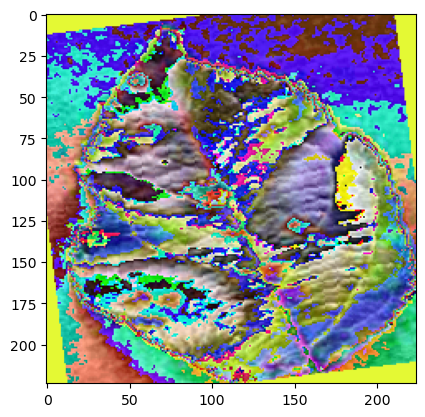

In [8]:
sample_image, _ = train_dataset[0]  
transform = transforms.ToPILImage()
sample_image = transform(sample_image)
plt.imshow(sample_image)
plt.show()

In [9]:
model = CNN(in_channels=3,num_classes=4)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = learning_rate)


In [10]:

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    num_correct = 0
    num_samples = 0
    train_loss = 0
    
    model.train()  # Set the model to training mode
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)
        
        scores = model(data)
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predictions = scores.max(1)
        train_loss += loss.item()
        num_correct += (predictions == targets).sum().item()
        num_samples += data.size(0)
    
    train_losses.append(train_loss / num_samples) 
    train_accuracies.append((num_correct / num_samples) * 100)
    
    model.eval()  # Set the model to evaluation mode
    
    num_correct = 0
    num_samples = 0
    val_loss = 0
    val_targets = []
    val_predictions = []
    
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(val_loader):
            x = x.to(device)
            y = y.to(device)
            
            scores = model(x)
            loss = criterion(scores, y)
            
            _, predictions = scores.max(1)
            val_loss += loss.item() 
            num_correct += (predictions == y).sum().item()
            num_samples += x.size(0)
            val_predictions.extend(predictions.cpu().numpy())
            val_targets.extend(y.cpu().numpy())
    
    epoch_val_loss = (val_loss / num_samples)
    val_losses.append(epoch_val_loss)
    
    epoch_val_acc = (num_correct / num_samples) * 100
    val_accuracies.append(epoch_val_acc)
    print(f'Epoch: {epoch+1}/{epochs} | Validation Accuracy: {epoch_val_acc:.2f} | Validation Loss: {epoch_val_loss:.4f}')

print(f'Final Validation Accuracy: {epoch_val_acc:.2f} | Final Validation Loss: {epoch_val_loss:.4f}')

val_report = classification_report(val_targets, val_predictions, target_names=train_dataset.classes)
print('Classification Report - Validation Data')
print(val_report)

model.train()  # Set the model back to training mode


Epoch: 1/50 | Validation Accuracy: 83.20 | Validation Loss: 0.0071
Epoch: 2/50 | Validation Accuracy: 87.11 | Validation Loss: 0.0052
Epoch: 3/50 | Validation Accuracy: 88.35 | Validation Loss: 0.0048
Epoch: 4/50 | Validation Accuracy: 86.33 | Validation Loss: 0.0057
Epoch: 5/50 | Validation Accuracy: 91.73 | Validation Loss: 0.0036
Epoch: 6/50 | Validation Accuracy: 89.71 | Validation Loss: 0.0047
Epoch: 7/50 | Validation Accuracy: 91.34 | Validation Loss: 0.0036
Epoch: 8/50 | Validation Accuracy: 91.80 | Validation Loss: 0.0037
Epoch: 9/50 | Validation Accuracy: 92.58 | Validation Loss: 0.0035
Epoch: 10/50 | Validation Accuracy: 94.08 | Validation Loss: 0.0027
Epoch: 11/50 | Validation Accuracy: 94.73 | Validation Loss: 0.0029
Epoch: 12/50 | Validation Accuracy: 92.64 | Validation Loss: 0.0035
Epoch: 13/50 | Validation Accuracy: 93.82 | Validation Loss: 0.0032
Epoch: 14/50 | Validation Accuracy: 95.44 | Validation Loss: 0.0025
Epoch: 15/50 | Validation Accuracy: 89.84 | Validation Lo

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=86528, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

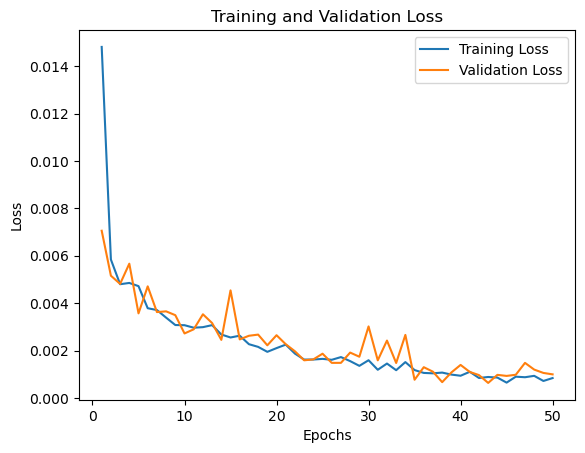

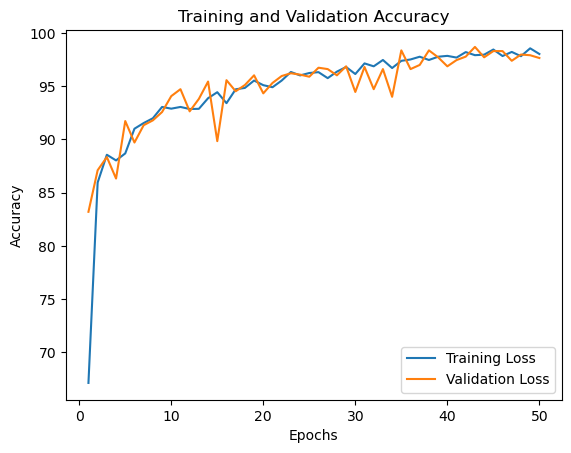

In [11]:
epochs = range(1,len(train_losses)+1)
plt.figure()
plt.plot(epochs,train_losses,label='Training Loss')
plt.plot(epochs,val_losses,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.figure()
plt.plot(epochs,train_accuracies,label='Training Loss')
plt.plot(epochs,val_accuracies,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [12]:


model.eval()
num_correct = 0
num_samples = 0
test_loss = 0
test_targets = []
test_predictions = []
test_losses = []
test_accuracies = []

with torch.no_grad():
    for batch_idx, (x, y) in enumerate(test_loader):
        x = x.to(device)
        y = y.to(device)

        scores = model(x)
        loss = criterion(scores, y)

        _, predictions = scores.max(1)
        test_loss += loss.item()
        num_correct += (predictions == y).sum().item()
        num_samples += x.size(0)
        test_predictions.extend(predictions.cpu().numpy())
        test_targets.extend(y.cpu().numpy())

epoch_test_loss = (test_loss / num_samples)
epoch_test_acc = (num_correct / num_samples) * 100

test_losses.append(epoch_test_loss)
test_accuracies.append(epoch_test_acc)

print(f'Test Accuracy: {epoch_test_acc:.2f} | Test Loss: {epoch_test_loss:.4f}')

test_report = classification_report(test_targets, test_predictions, target_names=test_dataset.classes)
print('Classification Report - Test Data')
print(test_report)

model.train()


Test Accuracy: 98.33 | Test Loss: 0.0008
Classification Report - Test Data
                  precision    recall  f1-score   support

      apple_scab       0.99      0.96      0.98       504
       black_rot       0.97      1.00      0.98       497
cedar_apple_rust       1.00      1.00      1.00       440
         healthy       0.98      0.98      0.98       479

        accuracy                           0.98      1920
       macro avg       0.98      0.98      0.98      1920
    weighted avg       0.98      0.98      0.98      1920



CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=86528, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)